## 필요 모듈 불러오기

In [37]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
#from skimage.io import imread
#from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## Albumentation 적용

In [38]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

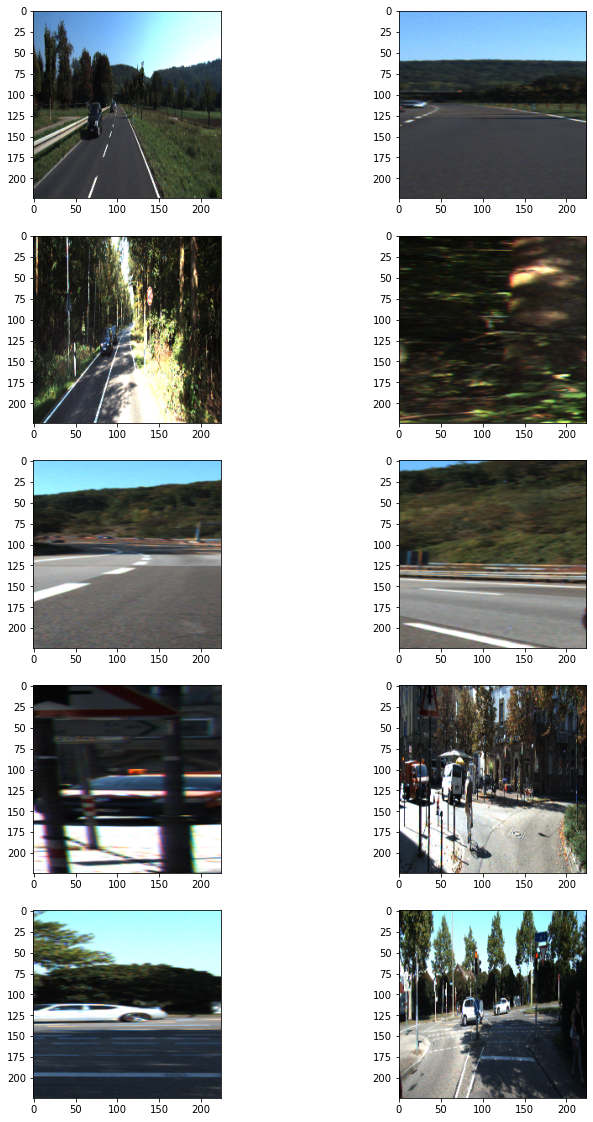

In [39]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

## 데이터셋 구성

In [40]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [41]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 모델 구조 만들기(U-Net)

In [42]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
    Conv2DTranspose(512, 2, strides=(2,2), kernel_initializer='he_normal')(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
    Conv2DTranspose(256, 2, strides=(2,2), kernel_initializer='he_normal')(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
    Conv2DTranspose(128, 2, strides=(2,2), kernel_initializer='he_normal')(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(
    Conv2DTranspose(64, 2, strides=(2,2), kernel_initializer='he_normal')(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

## 모델 학습(U-Net)

In [48]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=300,
 )

model_path = dir_path + '/seg_model_unet1.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/300
11/11 [==============================] - 8s 657ms/step - loss: 0.6966 - val_loss: 0.6587
Epoch 2/300
11/11 [==============================] - 7s 635ms/step - loss: 0.6388 - val_loss: 0.4606
Epoch 3/300
11/11 [==============================] - 7s 632ms/step - loss: 0.2142 - val_loss: 0.0313
Epoch 4/300
11/11 [==============================] - 7s 629ms/step - loss: 0.0335 - val_loss: 0.0313
Epoch 5/300
11/11 [==============================] - 7s 601ms/step - loss: 0.0293 - val_loss: 0.0287
Epoch 6/300
11/11 [==============================] - 7s 602ms/step - loss: 0.0283 - val_loss: 0.0291
Epoch 7/300
11/11 [==============================] - 7s 598ms/step - loss: 0.0313 - val_loss: 0.0255
Epoch 8/300
11/11 [==============================] - 7s 609ms/step - loss: 0.0231 - val_loss: 0.0251
Epoch 9/300
11/11 [==============================] - 6s 580ms/step - loss: 0.0224 - val_loss: 0.0267
Epoch 10/300
11/11 [==============================] - 6s 573ms/step - loss: 0.0254 - val_lo

11/11 [==============================] - 7s 651ms/step - loss: 0.0088 - val_loss: 0.0178
Epoch 82/300
11/11 [==============================] - 7s 651ms/step - loss: 0.0095 - val_loss: 0.0180
Epoch 83/300
11/11 [==============================] - 7s 651ms/step - loss: 0.0098 - val_loss: 0.0203
Epoch 84/300
11/11 [==============================] - 7s 652ms/step - loss: 0.0107 - val_loss: 0.0172
Epoch 85/300
11/11 [==============================] - 7s 651ms/step - loss: 0.0100 - val_loss: 0.0176
Epoch 86/300
11/11 [==============================] - 7s 650ms/step - loss: 0.0074 - val_loss: 0.0173
Epoch 87/300
11/11 [==============================] - 7s 651ms/step - loss: 0.0111 - val_loss: 0.0164
Epoch 88/300
11/11 [==============================] - 7s 654ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 89/300
11/11 [==============================] - 7s 633ms/step - loss: 0.0109 - val_loss: 0.0212
Epoch 90/300
11/11 [==============================] - 7s 650ms/step - loss: 0.0116 - val_loss: 

Epoch 161/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0093 - val_loss: 0.0133
Epoch 162/300
11/11 [==============================] - 6s 576ms/step - loss: 0.0072 - val_loss: 0.0145
Epoch 163/300
11/11 [==============================] - 6s 576ms/step - loss: 0.0060 - val_loss: 0.0152
Epoch 164/300
11/11 [==============================] - 6s 578ms/step - loss: 0.0064 - val_loss: 0.0126
Epoch 165/300
11/11 [==============================] - 6s 578ms/step - loss: 0.0144 - val_loss: 0.0136
Epoch 166/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0067 - val_loss: 0.0128
Epoch 167/300
11/11 [==============================] - 7s 604ms/step - loss: 0.0054 - val_loss: 0.0132
Epoch 168/300
11/11 [==============================] - 6s 577ms/step - loss: 0.0059 - val_loss: 0.0139
Epoch 169/300
11/11 [==============================] - 6s 576ms/step - loss: 0.0062 - val_loss: 0.0148
Epoch 170/300
11/11 [==============================] - 6s 577ms/step - lo

11/11 [==============================] - 6s 575ms/step - loss: 0.0063 - val_loss: 0.0124
Epoch 241/300
11/11 [==============================] - 6s 574ms/step - loss: 0.0045 - val_loss: 0.0136
Epoch 242/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0039 - val_loss: 0.0123
Epoch 243/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0062 - val_loss: 0.0242
Epoch 244/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 245/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0081 - val_loss: 0.0155
Epoch 246/300
11/11 [==============================] - 6s 573ms/step - loss: 0.0073 - val_loss: 0.0151
Epoch 247/300
11/11 [==============================] - 6s 574ms/step - loss: 0.0066 - val_loss: 0.0147
Epoch 248/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0055 - val_loss: 0.0140
Epoch 249/300
11/11 [==============================] - 6s 575ms/step - loss: 0.0091 - v

## 모델 시각화(U-Net)

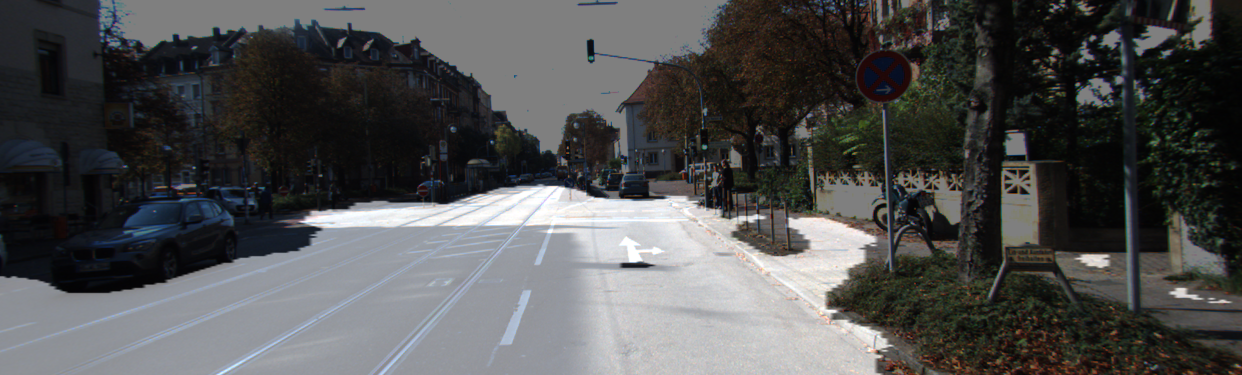

In [49]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
  
  
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

## IOU 계산

In [50]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [51]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [52]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.590237


0.5902372511589855

In [53]:
# U-Net++ 모델 구현을 위한 추가 모듈 불러오기
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import concatenate


def build_model_unetplusplus(input_shape=(224, 224, 3)):
        inputs = Input(input_shape)

        #Contracting Path
        conv1_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        BatchNorm1_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv1_1)
        ReLU1_1 = Activation('relu')(BatchNorm1_1)
        conv1_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU1_1)
        drop1_2 = Dropout(0)(conv1_2)
        Merge1 = concatenate([conv1_1,drop1_2], axis = 3)
        pool1 = MaxPooling2D(pool_size=(2, 2))(Merge1)

        conv2_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        BatchNorm2_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv2_1)
        ReLU2_1 = Activation('relu')(BatchNorm2_1)
        conv2_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU2_1)
        drop2_2 = Dropout(0)(conv2_2)
        Merge2 = concatenate([conv2_1,drop2_2], axis = 3)
        pool2 = MaxPooling2D(pool_size=(2, 2))(Merge2)

        conv3_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        BatchNorm3_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv3_1)
        ReLU3_1 = Activation('relu')(BatchNorm3_1)
        conv3_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU3_1)
        drop3_2 = Dropout(0)(conv3_2)
        Merge3 = concatenate([conv3_1,drop3_2], axis = 3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(Merge3)

        conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        BatchNorm4_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv4_1)
        ReLU4_1 = Activation('relu')(BatchNorm4_1)
        conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU4_1)
        drop4_2 = Dropout(0)(conv4_2)
        Merge4 = concatenate([conv4_1,drop4_2], axis = 3)
        drop4 = Dropout(0.5)(Merge4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5_1 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        BatchNorm5_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv5_1)
        ReLU5_1 = Activation('relu')(BatchNorm5_1)
        conv5_2 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU5_1)
        drop5_2 = Dropout(0)(conv5_2)
        Merge5 = concatenate([conv5_1,drop5_2], axis = 3)
        drop5 = Dropout(0.5)(Merge5)

        #Expanding Path
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        BatchNorm6_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv6_1)
        ReLU6_1 = Activation('relu')(BatchNorm6_1)
        conv6_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU6_1)
        drop6_2 = Dropout(0)(conv6_2)
        Merge6 = concatenate([conv6_1,drop6_2], axis = 3)

        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Merge6))
        merge7 = concatenate([Merge3,up7], axis = 3)
        conv7_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        BatchNorm7_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv7_1)
        ReLU7_1 = Activation('relu')(BatchNorm7_1)
        conv7_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU7_1)
        drop7_2 = Dropout(0)(conv7_2)
        Merge7 = concatenate([conv7_1,drop7_2], axis = 3)

        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Merge7))
        merge8 = concatenate([Merge2,up8], axis = 3)
        conv8_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        BatchNorm8_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv8_1)
        ReLU8_1 = Activation('relu')(BatchNorm8_1)
        conv8_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU8_1)
        drop8_2 = Dropout(0)(conv8_2)
        Merge8 = concatenate([conv8_1,drop8_2], axis = 3)

        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(Merge8))
        merge9 = concatenate([Merge1,up9], axis = 3)
        conv9_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        BatchNorm9_1 = BatchNormalization(axis=3, gamma_regularizer=l2(1e-4), beta_regularizer=l2(1e-4))(conv9_1)
        ReLU9_1 = Activation('relu')(BatchNorm9_1)
        conv9_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ReLU9_1)
        drop9_2 = Dropout(0)(conv9_2)
        Merge9 = concatenate([conv9_1,drop9_2], axis = 3)

        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Merge9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

        model = Model(inputs = inputs, outputs = conv10)
        return model

In [54]:
model1 = build_model_unetplusplus()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=300,
 )

model_path = dir_path + '/seg_model_unetplusplus1.h5'
model1.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/300
11/11 [==============================] - 7s 579ms/step - loss: 0.0038 - val_loss: 0.0140
Epoch 2/300
11/11 [==============================] - 6s 543ms/step - loss: 0.0068 - val_loss: 0.0126
Epoch 3/300
11/11 [==============================] - 6s 587ms/step - loss: 0.0067 - val_loss: 0.0106
Epoch 4/300
11/11 [==============================] - 6s 555ms/step - loss: 0.0101 - val_loss: 0.0122
Epoch 5/300
11/11 [==============================] - 7s 610ms/step - loss: 0.0055 - val_loss: 0.0116
Epoch 6/300
11/11 [==============================] - 6s 589ms/step - loss: 0.0053 - val_loss: 0.0126
Epoch 7/300
11/11 [==============================] - 7s 614ms/step - loss: 0.0060 - val_loss: 0.0142
Epoch 8/300
11/11 [==============================] - 6s 557ms/step - loss: 0.0043 - val_loss: 0.0114
Epoch 9/300
11/11 [==============================] - 6s 557ms/step - loss: 0.0047 - val_loss: 0.0119
Epoch 10/300
11/11 [==============================] - 6s 558ms/step - loss: 0.0034 - val_lo

11/11 [==============================] - 6s 573ms/step - loss: 0.0045 - val_loss: 0.0135
Epoch 82/300
11/11 [==============================] - 6s 571ms/step - loss: 0.0054 - val_loss: 0.0135
Epoch 83/300
11/11 [==============================] - 6s 573ms/step - loss: 0.0048 - val_loss: 0.0140
Epoch 84/300
11/11 [==============================] - 6s 563ms/step - loss: 0.0050 - val_loss: 0.0180
Epoch 85/300
11/11 [==============================] - 6s 581ms/step - loss: 0.0037 - val_loss: 0.0145
Epoch 86/300
11/11 [==============================] - 6s 550ms/step - loss: 0.0054 - val_loss: 0.0109
Epoch 87/300
11/11 [==============================] - 6s 561ms/step - loss: 0.0044 - val_loss: 0.0112
Epoch 88/300
11/11 [==============================] - 6s 584ms/step - loss: 0.0026 - val_loss: 0.0115
Epoch 89/300
11/11 [==============================] - 6s 563ms/step - loss: 0.0031 - val_loss: 0.0149
Epoch 90/300
11/11 [==============================] - 6s 549ms/step - loss: 0.0040 - val_loss: 

Epoch 161/300
11/11 [==============================] - 6s 568ms/step - loss: 0.0028 - val_loss: 0.0115
Epoch 162/300
11/11 [==============================] - 6s 535ms/step - loss: 0.0028 - val_loss: 0.0118
Epoch 163/300
11/11 [==============================] - 6s 535ms/step - loss: 0.0040 - val_loss: 0.0119
Epoch 164/300
11/11 [==============================] - 6s 535ms/step - loss: 0.0071 - val_loss: 0.0106
Epoch 165/300
11/11 [==============================] - 6s 535ms/step - loss: 0.0039 - val_loss: 0.0128
Epoch 166/300
11/11 [==============================] - 6s 536ms/step - loss: 0.0036 - val_loss: 0.0111
Epoch 167/300
11/11 [==============================] - 6s 538ms/step - loss: 0.0032 - val_loss: 0.0114
Epoch 168/300
11/11 [==============================] - 6s 534ms/step - loss: 0.0023 - val_loss: 0.0145
Epoch 169/300
11/11 [==============================] - 6s 534ms/step - loss: 0.0027 - val_loss: 0.0119
Epoch 170/300
11/11 [==============================] - 6s 535ms/step - lo

11/11 [==============================] - 6s 532ms/step - loss: 0.0038 - val_loss: 0.0135
Epoch 241/300
11/11 [==============================] - 6s 533ms/step - loss: 0.0064 - val_loss: 0.0097
Epoch 242/300
11/11 [==============================] - 6s 533ms/step - loss: 0.0068 - val_loss: 0.0097
Epoch 243/300
11/11 [==============================] - 6s 532ms/step - loss: 0.0036 - val_loss: 0.0116
Epoch 244/300
11/11 [==============================] - 6s 533ms/step - loss: 0.0033 - val_loss: 0.0129
Epoch 245/300
11/11 [==============================] - 6s 532ms/step - loss: 0.0024 - val_loss: 0.0120
Epoch 246/300
11/11 [==============================] - 6s 533ms/step - loss: 0.0028 - val_loss: 0.0107
Epoch 247/300
11/11 [==============================] - 6s 533ms/step - loss: 0.0034 - val_loss: 0.0104
Epoch 248/300
11/11 [==============================] - 6s 533ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 249/300
11/11 [==============================] - 6s 545ms/step - loss: 0.0038 - v

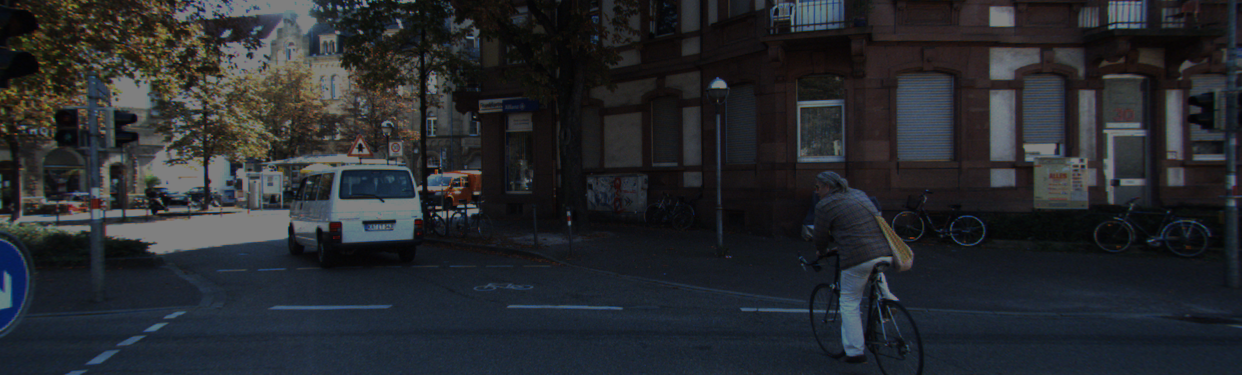

In [55]:
def get_output(model1, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model1(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
  
  
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [56]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [57]:
def get_output(model1, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model1(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [58]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 45    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.018920


0.018919613046828182